In [1]:
import pandas as pd 
import numpy as np
from Response_Spectrum import *
from Base_Isolation_Calculation import *




In [123]:
def Multimode(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,PGA, S_1,S_S, SiteClass,q,k,tol,T_max, isolator_type):
    
    isolator_type = ["friction-based isolators", 'others'] 
    
    """
    m: Number of supports
    
    n: Number of girders per support
    
    n_c=[0,3,3,0]: Number of columns per support
    ** abutment1, 2 there are no columns
        number of columns = 3 in each pie 1 and 2 
        
    q:    percent of the bridge weight
    
    k:  the increased parameter of  post-yield stiffness      
    
    W_SS: Weight of superstructure including railings, curbs,and barriers to the permanent loads
    
    W_PP: Weight of piers participating with superstructure in dynamic response
    
    W_eff= W_SS + W_PP: Effective weight
    
    W=[W_1,W_2,...,W_m]: Weight of superstructure at each support
    
    K_sub=[K_sub_abut1, K_sub_pie1, K_sub_pie2, K_sub_abut2]: Stiffness of each support in both longitudinal and transverse directions of the bridge
    ** For the abutments, take Ksub,j to be a large number, say 10,000 kips/in.
    
    angle_skew: Angle of skew
    
    PGA,S_1, S_S: Acceleration coefficients for bridge site are given in design statement
    
    SiteClass:  "A", "B", "C","D","E"
    
    epsilon: tolerance
    
    d: set initial guess for the first iteration
 
    """
    
    # Round the values in each column to n decimal places
    def round_values(x,n):
        try:
            return round(x, n)
        except:
            return x

    # Apply the e-4 formatting to numeric columns
    def scientific_format(x):
        try:
            float_value = float(x)
            return '{:.2e}'.format(float_value).replace('+', '')
        except:
            return x

    
    
   
    
# Calculate Response Spectrum:
    # Create a array of time:
    shape=200
    t=np.linspace(0,T_max,shape)
    # Call the Response Spectrum function
    C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(t, PGA,S_S,S_1,SiteClass) 
    
    # Plot Design Response Spectrum
    plt.plot(t, C_sm)
    plt.title(f"Design Response Spectrum for PGA={PGA}, S_S={S_S}, S_1= {S_1}, SiteClass={SiteClass}")
    plt.xlabel(f'Period')
    plt.ylabel(f'Acceleration')
    plt.show()
    
        
# Step 1: Iteration
    iter=1
    
    d=10*S_D1
    
    data={}
  
    while True:
        
        #print(f'iteration:{i} ')
        #print(f'd={d}')
        
        ##%% Calculate characteristic strength, Q_d
        Q_d=q*W_SS

        ##%% Calculate Post-yield stiffness, K_d
        K_d=k*(W_SS/d)

        ### B2.1.2.1.2—Step B1.2: Initial Isolator Properties at Supports

        ##%% Calculate the characteristic strength, Q_dj

        Q_dj=[Q_d*(W[j]/W_SS) for j in range(m)]

        ##%% Calculate postelastic stiffness, K_dj

        K_dj= [K_d*(W[j]/W_SS) for j in range(m)]
      

        ### B2.1.2.1.3—Step B1.3: Effective Stiffness of Combined Pier and Isolator System

        ##%% Calculate alpha_j

        alpha_j = [(K_dj[j]*d+Q_dj[j])/(K_sub[j]*d-Q_dj[j]) for j in range(m)]

        ##%% Calculate the effective stiffness, K_effj

        K_effj=[(alpha_j[j]*K_sub[j])/(1+alpha_j[j]) for j in range(m)]

        ### B2.1.2.1.4—Step B1.4: Total Effective Stiffness

        ##%% Calculate the total effective stiffness, Keff, of the bridge:

        K_eff= sum(K_effj)
        #print(f'K_eff: {K_eff}')

        ### B2.1.2.1.5—Step B1.5: Isolation System Displacement at Each Suppor

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isolj=  [d/(1+ alpha_j[j]) for j in range(m)]
        
        #print(f'd_isolj: {d_isolj}')

        ### B2.1.2.1.6—Step B1.6: Isolation System Stiffness at Each Support

        ##%% Calculate the effective stiffness of the isolation system at support “j”, Kisol,j, for all supports

        K_isolj=[Q_dj[j]/d_isolj[j]+ K_dj[j] for j in range(m)]

        ### 2.1.2.1.7—Step B1.7: Substructure Displacement at Each Support, d_subj

        d_subj= [d- d_isolj[j] for j in range(m)]

        ### B2.1.2.1.8—Step B1.8: Lateral Load in Each Substructure Support

        ##%% Calculate the shear at support “j”, Fsub,j, for all supports:

        F_subj= [K_sub[j]* d_subj[j] for j in range(m)]

        ### B2.1.2.1.9—Step B1.9: Column Shear Force at Each Support

        F_coljk = [F_subj[j]/n_c[j] if n_c[j] != 0 else 0 for j in range(m)]

        ### B2.1.2.1.10—Step B1.10: Effective Period and Damping Ratio

        ##%% Calculate the effective period, T_eff 

        W_eff= W_SS + W_PP #  Effective weight, W_eff
        g=386.4 # (in./s^2) or 9.815(m/s^2)

        T_eff=2*np.pi* (W_eff/(g*K_eff))**(1/2)
        #print(f'T_eff: {T_eff}')

        ##%% Calculate the viscous damping ratio, ξ , of the bridge

        d_yj=[0]*m # taking d_yj=0

        numerator=2*sum([Q_dj[j]*(d_isolj[j]-d_yj[j]) for j in range(m)])

        denominator=np.pi*sum([K_effj[j]*(d_isolj[j]+d_subj[j])**2 for j in range(m)])

        xi= numerator/denominator

        ### B2.1.2.1.11—Step B1.11: Damping Factor

        ##%% Calculate the damping factor, B_L

        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))

        ##%%  Calculate the displacement, d_new

        d_new=(9.79*S_D1*T_eff)/B_L
        
        ##%%%%%%%%%%%%%%%%%%%%%
        ##%% Calculate the diference, abs(d_new-d) 

        difference=abs(d_new-d)
        #delta=difference/d

        ##%% Check the convergence condition:

        #if difference> epsilon:
        if difference> tol:
            d=d_new
            iter+=1

        else:
            break
            
            
    df = pd.DataFrame({"Pier": ["Abut1", "Pier1", "Pier2", "Abut2"],
                       "$$Q_d$$": Q_d,
                       "$$K_d$$": K_d,      
                       "$$Q_{d,j}$$":Q_dj,
                       "$$K_{d,j}$$":K_dj,
                       "$\\alpha_j$": alpha_j, 
                       "$$K_{eff,j}$$": K_effj,
                       "$$d_{isol,j}$$":d_isolj,
                       "$$K_{isol,j}$$": K_isolj,
                       "$$d_{sub,j}$$": d_subj, 
                       "d": d, "d_new": d_new,        
                       "$$F_{sub,j}$$":F_subj ,
                       "$$ F_{col,j,k}$$": F_coljk,
                       "$$T_{eff}$$": T_eff,
                       "$$K_{eff}$$":K_eff,
                       "$$\\xi$$":xi,
                       "$$B_{L}$$": B_L})

    data[iter]=df
    
    print(f'Numbers of iteratations: {iter}')
    
    # The minimum displacement requirement given by:
    
    d_min=(8*S_D1*T_eff)/B_L
    
    print(f'The minimum displacement requirement given by: d_min={d_min: .2f}')
    
       
    for k in data.keys():
        data[k]['Iteration']=k # Add new column to track the iteration
        for col in data[k].columns:
            if col in ["$\\alpha_j$", "$$d_{sub,j}$$"]:
                data[k][col]=data[k][col].apply(scientific_format)
            else:
                data[k][col]=data[k][col]. apply(round_values, n=2)
        data[k].set_index(['Iteration',"d", "d_new","$$Q_d$$","$$K_d$$","$$T_{eff}$$","$$K_{eff}$$","$$\\xi$$", "$$B_{L}$$", 'Pier'], inplace=True)
    
     # Concatenate the DataFrames from each iteration
    
    concat_df=pd.DataFrame()
   
    for k, df in data.items():
        concat_df = pd.concat([concat_df, df], ignore_index=False)
    
    
## Step 2: Multimode  
    """
    - The results from the Simplified Method (Step B1 in Article B2.1.2.1)
    are used to determine initial values for the equivalent spring elements for the isolators as a starting point in the
    iterative process. 
   
    """

   
    
    
    N=int((0.8*T_eff*shape)/T_max)
        
    C_sm[N:]=C_sm[N:]/B_L # C_sm is calculated by Response Spectrum, and B_L is the result from the last  convergence step.
    ## Show the plot here
    plt.plot(t, C_sm)
    plt.title(f"Design Response Spectrum Multi Modes for PGA={PGA}, S_S={S_S}, S_1= {S_1}, SiteClass={SiteClass}")
    plt.xlabel(f'Period')
    plt.ylabel(f'Acceleration')
    plt.show()
    
    ### Begin iterate
    iter_multimode=1
    d_multimode=d_new
    
    print(f'd_multimode {d_multimode}')
    
    data_multimode={}
        
    
    while True:
        ## B2.1.2.2.1—Step B2.1:Characteristic Strength

        ##%% Calculate the characteristic strength, Qd,i, and postelastic stiffness, Kd,i, of each isolator “i” 

        Q_di=[Q_dj[i]/n for i in range(m)]

        K_di=[K_dj[i]/n for i in range(m)]
        
        print(f'K_di={K_di}')

        ## B2.1.2.2.2—Step B2.2: Initial Stiffness and Yield Displacement

        ##%% Calculate the initial stiffness, Ku,i, and the yield displacement, dy,i, for each isolator “i”

        if isolator_type == "friction-based isolators":
            K_ui =[np.inf for i in range(m)]
            d_yi=[0]*m
        else:
            K_ui=[10*K_di[i] for i in range(m)]
            d_yi=[Q_di[i]/(K_ui[i]-K_di[i]) for i in range(m)]
        print(f'K_ui={K_ui}')
        print(f'd_yi={d_yi}')

        ## B2.1.2.2.3—Step B2.3: Isolator Effective Stiffness, Kisol,i

        ##%% Calculate the isolator stiffness, Kisol,i, of each isolator “i”

        k_isoli=[K_isolj[i]/n for i in range (m)] #(sample: n=6, m=4)

        ## B2.1.2.2.4—Step B2.4: ThreeDimensional Bridge Model

        ## B2.1.2.2.5—Step B2.5: Composite Design Response Spectrum
       

        ## B2.1.2.2.6—Step B2.6: Multimode Analysis of Finite Element Model
        
        #( Call the d_isolj from the previuos calculation)


        ## B2.1.2.2.8—Step B2.8: Update Kisol,i, Keff,j, ξ , and BL

        ##%% Use the calculated displacements in each isolator element to obtain new values of Kisol,i for each isolator

        K_isoli=[Q_di[i]/d_isolj[i]+K_di[i] for i in range(m)] # (d_isoli in the document) is d_isolj in the convergence step
        
        print(f'K_isoli={K_isoli}')
        ###%% Recalculate K_effj

        K_effj=[(K_sub[j]*sum(K_isoli))/(K_sub[j]+sum(K_isoli)) for j in range(m)]
        
        print(f'K_effj={K_effj}')

        ##%% Recalculate system damping ratio, ξ :
        d_isoli=d_isolj
        #d_yi=[Q_di[i]/(Kui[i]-K_di[i]) for i in range(m)]
        numerator=2*sum(sum([Q_di[i]*(d_isoli[i]-d_yi[i]) for i in range(m)]) for j in range(m))
                
        denominator= np.pi * sum(sum(K_effj[j] * (d_isoli[i] + d_subj[j])**2 for i in range(m)) for j in range(m))

        xi=numerator/denominator
        print(f'xi={xi}')
        
        ## Recalculate system damping factor, BL:
        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))
        print(f'B_L={B_L}')
        #Recalculate Keff

        K_eff=sum(K_effj)
        
        print(f'K_eff={K_eff}')

        # Recalculate T_eff

        T_eff= 2*np.pi*(W_eff/(g*K_eff))**(1/2)
        
        print(f'T_eff={T_eff}')

        ## Recalculate d
        d_multimode_new=(9.79*S_D1*T_eff)/B_L


        ##%% Calculate alpha_j

        alpha_i = [(K_di[i]*d_multimode_new+Q_di[i])/(K_sub[i]*d_multimode_new-Q_di[i]) for i in range(m)]

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isoli=  [d_multimode_new/(1+ alpha_i[i]) for i in range(m)]


        # Convergence check
        diff=abs(d_multimode_new-d_multimode)

        if diff>0.03:
            d_multimode=d_multimode_new
            iter_multimode+=1
        else:
            break
            
        print(f'd_multimode_new {d_multimode_new}')

            
     #superstructure displacements in the longitudinal (xL) and transverse (yL) directions are:
    x_L=d_isoli[0]*np.cos(angle_skew)
    y_L=d_isoli[0]*np.sin(angle_skew)

    # isolator displacements in the longitudinal (uL) and transverse (vL) directions are:
    u_L=[]
    v_L=[]
    # Abutment:
    u_L.append(d_isoli[0]*np.cos(angle_skew))
    v_L.append(d_isoli[0]*np.sin(angle_skew))

    #Piers:

    u_L.append(d_isoli[1]*np.cos(angle_skew))
    v_L.append(d_isoli[1]*np.sin(angle_skew))

    print(f'Numbers of iteratations: {iter_multimode}')

    # The minimum displacement requirement given by:

    #d_min=(8*S_D1*T_eff)/B_L

    #print(f'The minimum displacement requirement given by: d_min={d_min: .2f}')
    

    return data, concat_df,d_multimode,d_multimode_new,x_L, y_L,u_L,v_L
        
    
     

In [124]:
# Example 1.0:
m=4
n=6
n_c=[0,3,3,0]
q=0.05 # 5%
k=0.05
W_SS=650.52


W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="B"
T_max=2.0
isolator_type='others'


In [125]:
### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
array_step = np.linspace(0, T_max, 100)
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(array_step, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

#print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')

F_pga=1.0
F_a=1.0
F_v=1.0
A_S=0.4
S_DS=0.75
S_D1=0.2


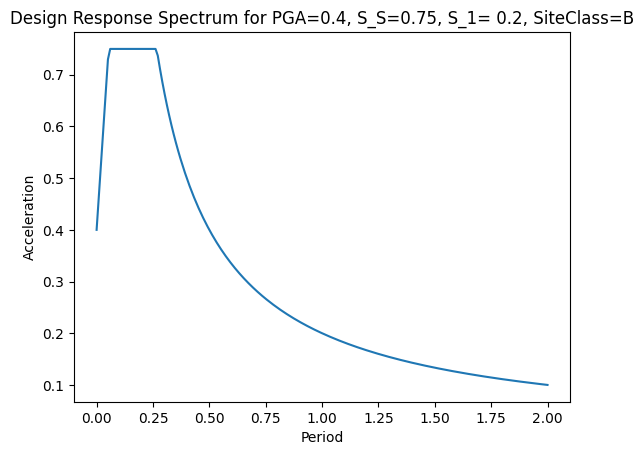

Numbers of iteratations: 3
The minimum displacement requirement given by: d_min= 1.37


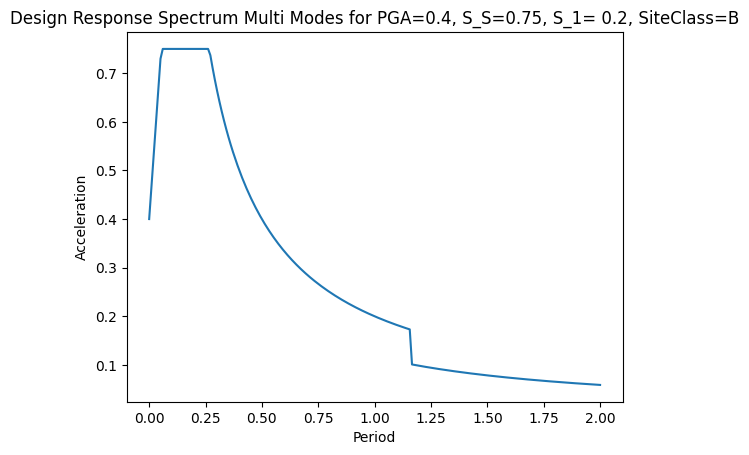

d_multimode 1.68162482187415
K_di=[0.217583862098336, 1.35686167708086, 1.35686167708086, 0.217583862098336]
K_ui=[2.17583862098336, 13.5686167708085, 13.5686167708085, 2.17583862098336]
d_yi=[0.191284270666913, 0.191284270666913, 0.191284270666913, 0.191284270666913]
K_isoli=[0.435224542898826, 2.84855211704982, 2.84855211704982, 0.435224542898826]
K_effj=[6.56324287514389, 6.32600464093643, 6.32600464093643, 6.56324287514389]
xi=0.0629123818488313
B_L=1.07134620863839
K_eff=25.7784950321606
T_eff=1.73290774053811
d_multimode_new 3.16707459140211
K_di=[0.217583862098336, 1.35686167708086, 1.35686167708086, 0.217583862098336]
K_ui=[2.17583862098336, 13.5686167708085, 13.5686167708085, 2.17583862098336]
d_yi=[0.191284270666913, 0.191284270666913, 0.191284270666913, 0.191284270666913]
K_isoli=[0.435224542898826, 2.84855211704982, 2.84855211704982, 0.435224542898826]
K_effj=[6.56324287514389, 6.32600464093643, 6.32600464093643, 6.56324287514389]
xi=0.0629123818488313
B_L=1.07134620863839


In [126]:
tol=0.05
data, concat_df,d_multimode,d_multimode_new,x_L, y_L,u_L,v_L=Multimode(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,PGA, S_1,S_S, SiteClass,q,k,tol,T_max,isolator_type)

In [113]:
concat_df

$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1         2.25   
                                                                               Pier1        14.02   
                                                                               Pier2        14.02   
                                                                               Abut2         2.25   

                                                                                     $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1        1.31   
                                                                               Pier1        8.14   
                                                                               Pier2        8.14   
                                                                               Abut2        1.31   

                                                                                     $\alpha_j$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier               
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1   2.61e-04   
                                                                               Pier1   9.94e-02   
                                                                               Pier2   9.94e-02   
                                                                               Abut2   2.61e-04   

                                                                                     $$K_{eff,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                  
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1          2.61   
                                                                               Pier1         15.55   
                                                                               Pier2         15.55   
                                                                               Abut2          2.61   

                                                                                     $$d_{isol,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1           1.72   
                                                                               Pier1           1.57   
                                                                               Pier2           1.57   
                                                                               Abut2           1.72   

                                                                                     $$K_{isol,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1           2.61   
                                                                               Pier1          17.09   
                                                                               Pier2          17.09   
                                                                               Abut2           2.61   

                                                                                     $$d_{sub,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                  
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1      4.49e-04   
                                                                               Pier1      1.56e-01   
                        

In [97]:
d_multimode

3.16479551743846

In [127]:
172*6.34/(172+6.34)

6.114612537849053